In [2]:
require(doParallel)

Loading required package: doParallel
Loading required package: foreach
Loading required package: iterators
Loading required package: parallel


In [3]:
source('01_hmm_fwdbwd.r')
source('01_hmm_loglike.r')
source('02_hmm_em.r')
source('02_shapeisequal.r')
source('10_shapesearch.r')
source('20_reduction.r')
source('30_compno_search.r')
source('40_initialization.r')

In [4]:
load(file = 'dat.RData')

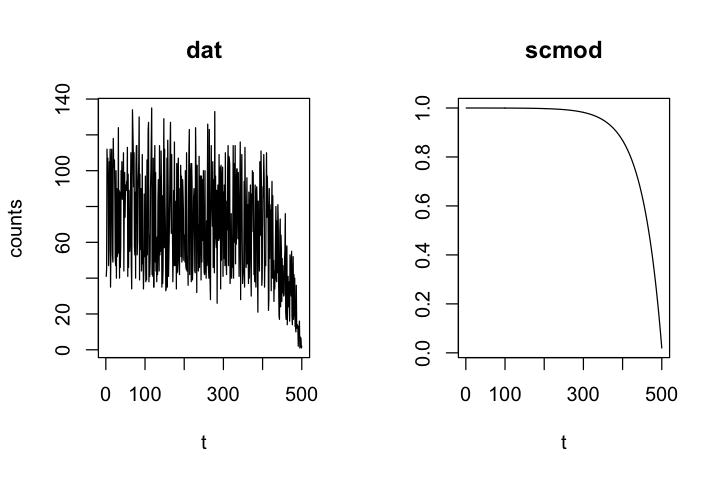

In [5]:
options(repr.plot.width=6, repr.plot.height=4)
par(mfrow=c(1, 2))

plot(dat, main='dat', type='l', xlab='t', ylab='counts')
plot(dat_scalemodifier, main='scmod', type='l', xlab='t', ylab='')

Check if rescale time series looks like something from a Hidden Markov Model.

(yes it does!)

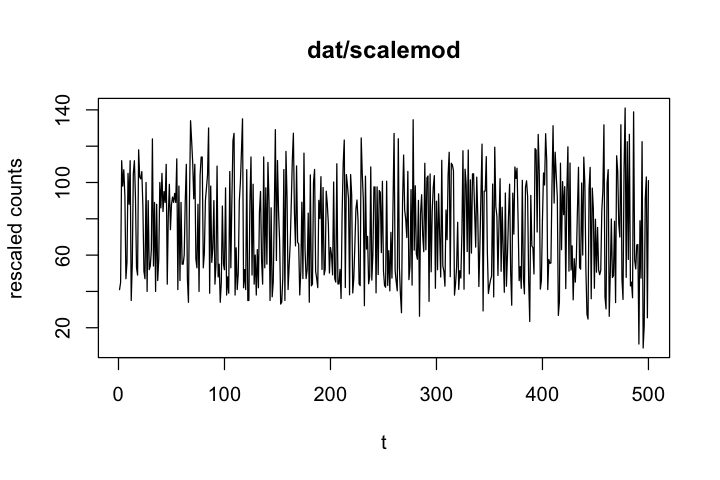

In [8]:
options(repr.plot.width=6, repr.plot.height=4)
plot(dat/dat_scalemodifier, main='dat/scalemod', type='l', xlab='t', ylab='rescaled counts')

In [5]:
nthreads = 8
totaljobs = 16
minspread = 1
maxspread = 100

In [6]:
base_spreads = as.integer(seq(minspread, maxspread, length=totaljobs))
base_shape = 1:4
shape_m = base_spreads %*% t(base_shape)
print (shape_m)

      [,1] [,2] [,3] [,4]
 [1,]    1    2    3    4
 [2,]    7   14   21   28
 [3,]   14   28   42   56
 [4,]   20   40   60   80
 [5,]   27   54   81  108
 [6,]   34   68  102  136
 [7,]   40   80  120  160
 [8,]   47   94  141  188
 [9,]   53  106  159  212
[10,]   60  120  180  240
[11,]   67  134  201  268
[12,]   73  146  219  292
[13,]   80  160  240  320
[14,]   86  172  258  344
[15,]   93  186  279  372
[16,]  100  200  300  400


In [7]:
worker = function(shape, dat, dat_scalemodifier, verbose = T) {
    t0 = proc.time()
    empars = empars_ini(shape, dat, dat_scalemodifier)
    mc_em_output = mc_em(dat, dat_scalemodifier, empars, verbose = verbose)
    out = em_compno_search(mc_em_output, dat, dat_scalemodifier, verbose = verbose)
    t1 = proc.time()
    
    if (verbose) {
        cat('shape:', shape, 'done in:', (t1-t0)['elapsed'])
    }
    
    return (out)
}

In [8]:
worker(shape_m[1,], dat, dat_scalemodifier)

iter 1 llk -2476.39 rdif 4.306776 
iter 2 llk -2428.086 rdif 2.57037 
iter 3 llk -2402.519 rdif 1.756956 
iter 4 llk -2387.812 rdif 1.236223 
iter 5 llk -2379.004 rdif 0.8937887 
iter 6 llk -2373.524 rdif 0.6770794 
iter 7 llk -2369.854 rdif 0.5542776 
iter 8 llk -2367.137 rdif 0.5055692 
iter 9 llk -2364.896 rdif 0.4948411 
iter 10 llk -2362.857 rdif 0.499429 
iter 11 llk -2360.853 rdif 0.5082471 
iter 12 llk -2358.782 rdif 0.5155008 
iter 13 llk -2356.595 rdif 0.5170411 
iter 14 llk -2354.292 rdif 0.5082081 
iter 15 llk -2351.915 rdif 0.4848193 
iter 16 llk -2349.543 rdif 0.4470004 
iter 17 llk -2347.266 rdif 0.405667 
iter 18 llk -2345.164 rdif 0.357524 
iter 19 llk -2343.293 rdif 0.3099604 
iter 20 llk -2341.672 rdif 0.2779306 
iter 21 llk -2340.296 rdif 0.254397 
iter 22 llk -2339.143 rdif 0.2479387 
iter 23 llk -2338.184 rdif 0.2433166 
iter 24 llk -2337.388 rdif 0.2402441 
iter 25 llk -2336.726 rdif 0.238257 
iter 26 llk -2336.174 rdif 0.2367819 
iter 27 llk -2335.712 rdif 0.235

1.893955e-01,0.8106045
8.832367e-09,1.0000000


In [9]:
cl = makePSOCKcluster(nthreads)
registerDoParallel(cl)

tstart = proc.time()
res <- foreach(i = 1:nrow(shape_m),
               .inorder = F,
               .errorhandling = 'remove',
               .export = ls(all.names=T),
               .verbose = T) %dopar% { 
    worker(shape_m[i,], dat, dat_scalemodifier)
}

print(proc.time()-tstart)
stopCluster(cl)

discovered package(s): 
automatically exporting the following variables from the local environment:
  aic, dat, dat_scalemodifier, drop_minweight, em_compno_search, empars_ini, loglike, mc_diff, mc_em, mc_emiter_single, mc_estep_statemarginal, mc_genlogbwd, mc_genlogfwd, mc_genlogprob_dnbinom, mc_mstep_next_hmmpars, mc_mstep_next_scale, reduce_comps, shape_m, shape_search, shape_search_single, shapeisequal, single_shape_change, single_shape_change_ttm, worker 


Warning message in e$fun(obj, substitute(ex), parent.frame(), e$data):
“already exporting variable(s): aic, dat, dat_scalemodifier, drop_minweight, em_compno_search, empars_ini, loglike, mc_diff, mc_em, mc_emiter_single, mc_estep_statemarginal, mc_genlogbwd, mc_genlogfwd, mc_genlogprob_dnbinom, mc_mstep_next_hmmpars, mc_mstep_next_scale, reduce_comps, shape_m, shape_search, shape_search_single, shapeisequal, single_shape_change, single_shape_change_ttm, worker”

explicitly exporting variables(s): .pbd_env, base_shape, base_spreads, cl, maxspread, minspread, nthreads, test, totaljobs, tstart
explicitly exporting package(s): 
numValues: 16, numResults: 0, stopped: TRUE
got results for task 1
numValues: 16, numResults: 1, stopped: TRUE
returning status FALSE
got results for task 2
numValues: 16, numResults: 2, stopped: TRUE
returning status FALSE
got results for task 3
numValues: 16, numResults: 3, stopped: TRUE
returning status FALSE
got results for task 4
numValues: 16, numResults: 4, stopped: TRUE
returning status FALSE
got results for task 5
numValues: 16, numResults: 5, stopped: TRUE
returning status FALSE
got results for task 6
numValues: 16, numResults: 6, stopped: TRUE
returning status FALSE
got results for task 7
numValues: 16, numResults: 7, stopped: TRUE
returning status FALSE
got results for task 8
numValues: 16, numResults: 8, stopped: TRUE
returning status FALSE
got results for task 9
numValues: 16, numResults: 9, stopped: TRUE
retu

In [10]:
save(res, file = 'fitres.RData')

In [11]:
# collect all results from different spreads
all_aics = c()
all_nstates = c()

for (model in res) {
    all_aics = c(all_aics, model$aic)
    all_nstates = c(all_nstates, length(model$empars$pars_list$shapes))
}

In [12]:
min_aic = min(all_aics)
min_aic_dex = which.min(all_aics)
cat('min aic is:', min_aic,
    'at dex:',     min_aic_dex,
    '\n')

min aic is: 4433.291 at dex: 5 


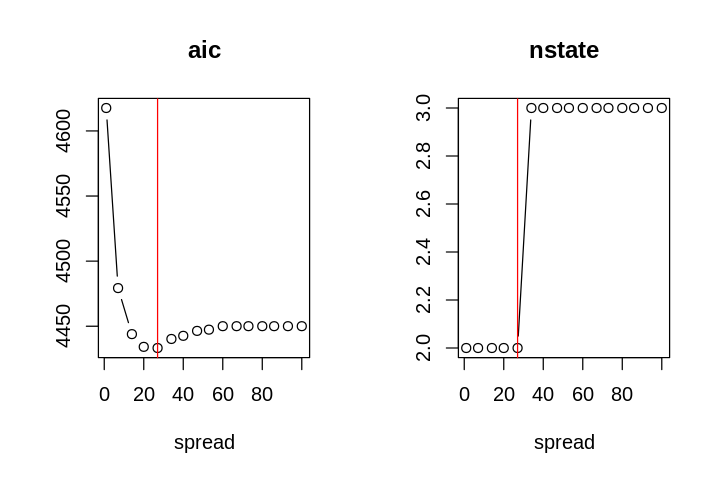

In [13]:
options(repr.plot.width=6, repr.plot.height=4)
par(mfrow=c(1, 2))

plot(base_spreads, all_aics, type='b', main='aic', xlab='spread', ylab='')
abline(v=base_spreads[min_aic_dex], col='red')
plot(base_spreads, all_nstates, type='b', main='nstate', xlab='spread', ylab='')
abline(v=base_spreads[min_aic_dex], col='red')

# Do we recover parameters from true arrivals?

In [14]:
bestmodel=res[[min_aic_dex]]
print (list('iniprob'=bestmodel$empars$mc_iniprob,
            'transprob'=bestmodel$empars$mc_transition,
            'shapes'=bestmodel$empars$pars_list$shapes,
            'scale'=bestmodel$empars$pars_list$scale))

$iniprob
[1]  1.000000e+00 6.002081e-101

$transprob
          [,1]      [,2]
[1,] 0.4774417 0.5225583
[2,] 0.5082304 0.4917696

$shapes
[1]  54 111

$scale
[1] 0.9002294



In [15]:
load('truemodel.RData')
print (truemodel)

$iniprob
[1] 1 0

$transprob
     [,1] [,2]
[1,]  0.5  0.5
[2,]  0.5  0.5

$shapes
[1]  50 100

$scale
[1] 1

